In [1]:
import sqlalchemy as db
import numpy as np
import pandas as pd
import pyodbc
import yaml
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import umap
import umap.plot

# custom functions imports
import MS_Functions as f

C:\Users\Marija\anaconda3\envs\process-optimization\lib\site-packages\umap\__init__.py:9: UserWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn("Tensorflow not installed; ParametricUMAP will be unavailable")


In [2]:
db_config_file_path = '../db_config.yml'
db_config = yaml.safe_load(open(db_config_file_path))

In [3]:
engine = db.create_engine('{DB_DRIVER}://{DB_USERNAME}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}?driver={DB_ODBC_DRIVER}'.format(**db_config))

In [4]:
sql = """
SELECT 
ps.[PRIMARY] , 
ps.ID ,
ps.INSDATE,
ps.MA_NR ,
ps.WSG_ID ,
ps.WZS_ID ,
ps.WZD_ID ,
ps.KOR_ID ,
ps.ST_ID ,
ps.AT_ID ,
ps.PUS_ID ,
IMAX_R,
IMAX_L,
IRMS_R,
IRMS_L,
IINT_R,
IINT_L,
IMAX_R_abHUB2,
IRMS_R_abHUB2,
IINT_R_abHUB2,
POSI_X,
POSI_Y,
POSI_Y_L,
POSI_Z,
ORD1_R,
ORD2_R,
ORDz1_I_R,
ORDz2_I_R,
ORDz3_I_R,
ORDsum_R,
ORD1_L,
ORD2_L,
ORDz1_I_L,
ORDz2_I_L,
ORDz3_I_L,
ORDsum_L,
ORDb_aR,
ORDz1_aR,
ORDz2_aR,
ORDz3_aR,
ORDsum_aR,
ORDAmax_aR,
ORDFmax_aR,
ORDb_aL,
ORDz1_aL,
ORDz2_aL,
ORDz3_aL,
ORDsum_aL,
ORDAmax_aL,
ORDFmax_aL,
AXIS_C_ACTIVE,
FORCE_FAKTOR,
APM_SCHL_Aktiv,
SCHLEIFZEIT,
IRMS_V,
IMAX_Xanfahrt,
IINT_V,
VORSTUFE_AKTIV,
IMAX_V,
IINTOFF_R,
NIO,
CASE WHEN NIO=0 THEN 0 ELSE 1 END NIO_GROUP
FROM dbo.prozessmessung_schleifen ps 
WHERE WARM = 0
AND TEACH_ACTIVE = 0
AND READY = 1
AND MA_NR = 78635
AND WSG_ID IN (14, 15)
AND WZD_ID IN (10027, 22, 10026)
AND ST_ID IN (20371, 20365, 20366)
AND AT_ID IN (10082, 80);
"""

In [5]:
with engine.connect() as conn:
    df = pd.read_sql(sql=sql, con=conn)
    

In [6]:
df.shape

(113035, 62)

In [7]:
df.head()

,PRIMARY,ID,INSDATE,MA_NR,WSG_ID,WZS_ID,WZD_ID,KOR_ID,ST_ID,AT_ID,...,APM_SCHL_Aktiv,SCHLEIFZEIT,IRMS_V,IMAX_Xanfahrt,IINT_V,VORSTUFE_AKTIV,IMAX_V,IINTOFF_R,NIO,NIO_GROUP
0,4404800,823986,2020-12-01 22:32:24,78635,15,116588,10027,41624,20371,10082,...,0,26.790001,0.0,11.71285,0.0,0,0.0,18.04032,0,0
1,4404801,823987,2020-12-01 22:33:08,78635,15,116588,10027,41624,20371,10082,...,0,26.726999,0.0,11.63037,0.0,0,0.0,17.67050,0,0
2,4404802,823988,2020-12-01 22:33:41,78635,15,116588,10027,41624,20371,10082,...,0,26.754000,0.0,11.60951,0.0,0,0.0,18.69301,0,0
3,4404803,823989,2020-12-01 22:34:09,78635,15,116588,10027,41624,20371,10082,...,0,26.875000,0.0,11.65184,0.0,0,0.0,20.08293,0,0
4,4404804,823990,2020-12-01 22:34:42,78635,15,116588,10027,41624,20371,10082,...,0,26.773001,0.0,11.62409,0.0,0,0.0,19.76529,0,0


In [33]:
# remove columns with zero standard deviation, NULL values more than 5% of total data, and ID columns
df_model = df[df.drop('INSDATE', axis=1).columns.values[df.agg('std') != 0]]
df_model = df_model.drop(df_model.columns.values[df_model.isna().sum()>0.05 * df_model.shape[0]], axis=1)
df_model = df_model.drop(['PRIMARY', 'ID', 'WSG_ID', 'WZS_ID', 'WZD_ID', 'KOR_ID', 'ST_ID', 'AT_ID', 'PUS_ID', 'NIO', 'NIO_GROUP'], axis=1)

In [51]:
df_input_type = df[['WSG_ID', 'WZD_ID', 'ST_ID', 'AT_ID']].astype(str).agg('-'.join, axis=1)

In [61]:
df_input_type.value_counts()

15-10027-20371-10082    58710
14-22-20365-80          27206
15-10026-20366-10082    16868
15-10026-20371-10082    10251
dtype: int64

In [34]:
df_model.shape

(113035, 36)

In [36]:
df_model.describe().T

,count,mean,std,min,25%,50%,75%,max
IMAX_R,113035.0,17.921254,1.462514,0.000000,16.905370,18.026400,18.949380,33.962990
IMAX_L,113035.0,10.863914,0.925972,0.000000,10.074830,10.906820,11.625435,14.855610
IRMS_R,113035.0,17.919980,1.462617,0.000000,16.904385,18.024891,18.947895,33.928040
IRMS_L,113035.0,10.863654,0.925966,0.000000,10.074530,10.906590,11.625175,14.855280
IINT_R,113035.0,92.680413,11.383104,0.000000,84.304897,94.137108,101.396648,153.821106
IINT_L,113035.0,78.019844,7.539408,0.000000,73.036640,78.248390,82.385315,111.702103
IMAX_R_abHUB2,113035.0,19.098374,1.756492,0.000000,17.568815,19.899441,20.418850,24.112511
IRMS_R_abHUB2,113035.0,19.097833,1.756440,0.000000,17.567941,19.898830,20.418130,24.112440
IINT_R_abHUB2,113035.0,93.680170,11.719628,0.000000,82.408497,96.825844,102.629650,193.871902
POSI_X,113035.0,88.941737,7.300881,0.000000,83.658699,89.109001,94.057800,245.022003


UMAP dimensionality reduction

In [37]:
reducer_cosine = umap.UMAP(metric='cosine')
sc = StandardScaler()
reducer_pipeline = Pipeline(steps=[('scale', sc), 
                                   ('reduce', reducer_cosine)])

In [38]:
cosine_embeddings = pd.DataFrame(reducer_pipeline.fit_transform(df_model))

<AxesSubplot:>

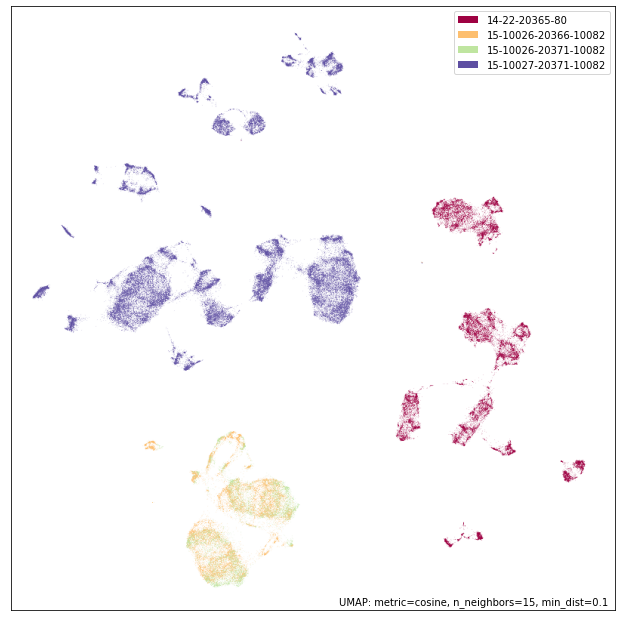

In [79]:
umap.plot.points(reducer_cosine, labels = df_input_type)

In [70]:
df_model_1 = df_model.loc[(df['WSG_ID']==15)
                     & (df['WZD_ID']==10027)
                     & (df['ST_ID']==20371)
                     & (df['AT_ID']==10082), :]

df_NIO_labels_1 = df['NIO_GROUP'][(df['WSG_ID']==15)
                            & (df['WZD_ID']==10027)
                            & (df['ST_ID']==20371)
                            & (df['AT_ID']==10082)]


In [67]:
reducer_cosine_1 = umap.UMAP(metric='cosine')
sc_1 = StandardScaler()
reducer_pipeline_1 = Pipeline(steps=[('scale', sc_1), 
                                   ('reduce', reducer_cosine_1)])

In [68]:
cosine_embeddings_1 = pd.DataFrame(reducer_pipeline_1.fit_transform(df_model_1))

<AxesSubplot:>

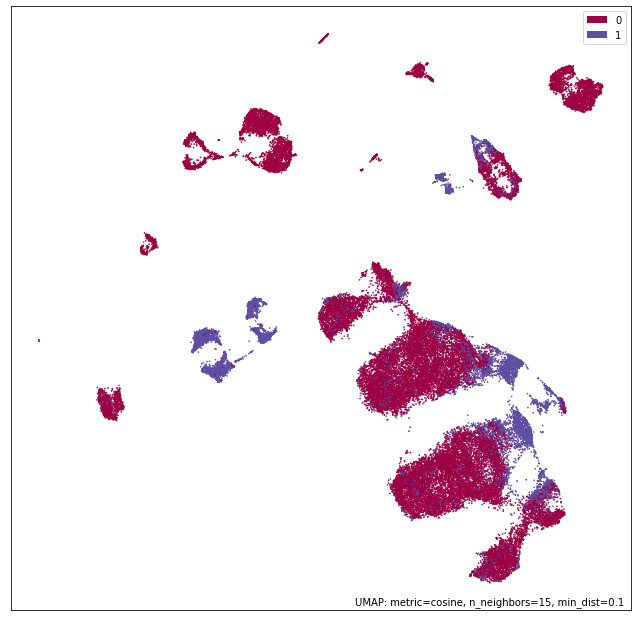

In [89]:
umap.plot.points(reducer_cosine_1, labels=df_NIO_labels_1)

In [82]:
df_model_1.columns

Index(['IMAX_R', 'IMAX_L', 'IRMS_R', 'IRMS_L', 'IINT_R', 'IINT_L',
       'IMAX_R_abHUB2', 'IRMS_R_abHUB2', 'IINT_R_abHUB2', 'POSI_X', 'POSI_Y',
       'POSI_Y_L', 'POSI_Z', 'ORD1_R', 'ORD2_R', 'ORDsum_R', 'ORD1_L',
       'ORD2_L', 'ORDsum_L', 'ORDb_aR', 'ORDz1_aR', 'ORDz2_aR', 'ORDsum_aR',
       'ORDAmax_aR', 'ORDFmax_aR', 'ORDb_aL', 'ORDz1_aL', 'ORDz2_aL',
       'ORDsum_aL', 'ORDAmax_aL', 'ORDFmax_aL', 'AXIS_C_ACTIVE',
       'FORCE_FAKTOR', 'APM_SCHL_Aktiv', 'SCHLEIFZEIT', 'IMAX_Xanfahrt'],
      dtype='object')

In [85]:
reducer_default_1 = umap.UMAP()
sc_default_1 = StandardScaler()
reducer_default_pipeline_1 = Pipeline(steps=[('scale', sc_default_1), 
                                   ('reduce', reducer_default_1)])
reducer_default_pipeline_1.fit(df_model_1)

Pipeline(steps=[('scale', StandardScaler()),
                ('reduce', UMAP(dens_frac=0.0, dens_lambda=0.0))])

<AxesSubplot:>

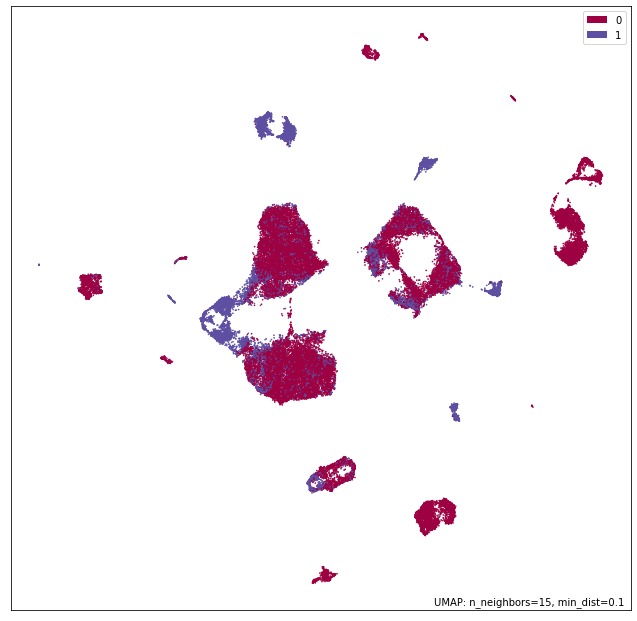

In [87]:
umap.plot.points(reducer_default_1, labels=df_NIO_labels_1)